# Analysis of Earthquake Frequency
### By Royce Schultz

The database is available on [Kaggle](https://www.kaggle.com/usgs/earthquake-database)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.special import gamma

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
Fields = ['Date','Time','Latitude','Longitude','Type','Magnitude'] # Only import used columns
df = pd.read_csv('database.csv', usecols=Fields)
df.head()

,Date,Time,Latitude,Longitude,Type,Magnitude
0,01/02/1965,13:44:18,19.246,145.616,Earthquake,6.0
1,01/04/1965,11:29:49,1.863,127.352,Earthquake,5.8
2,01/05/1965,18:05:58,-20.579,-173.972,Earthquake,6.2
3,01/08/1965,18:49:43,-59.076,-23.557,Earthquake,5.8
4,01/09/1965,13:32:50,11.938,126.427,Earthquake,5.8


In [3]:
# Cleaning
df = df[df.Date.str.len() < 15] # Removes 3 rows with malformed dates
df = df[df.Type.isin(['Earthquake'])] # removes explosions and rock bursts

In [4]:
# Calculations
df['Datetime'] = pd.to_datetime(df.Date +' '+ df.Time)
df['Year'] = df['Datetime'].map(lambda x: x.year)

df['Rounded_Magnitude'] = np.floor(df.Magnitude)

df['Last_Quake'] = df.Datetime.diff()
df = df[df['Last_Quake'].notna()]
df['Last_Quake_sec'] = df['Last_Quake'].map(lambda x: x.total_seconds()) # Last Quake (s)

df.reset_index(drop=True)

df.head()

,Date,Time,Latitude,Longitude,Type,Magnitude,Datetime,Year,Rounded_Magnitude,Last_Quake,Last_Quake_sec
1,01/04/1965,11:29:49,1.863,127.352,Earthquake,5.8,1965-01-04 11:29:49,1965,5.0,1 days 21:45:31,164731.0
2,01/05/1965,18:05:58,-20.579,-173.972,Earthquake,6.2,1965-01-05 18:05:58,1965,6.0,1 days 06:36:09,110169.0
3,01/08/1965,18:49:43,-59.076,-23.557,Earthquake,5.8,1965-01-08 18:49:43,1965,5.0,3 days 00:43:45,261825.0
4,01/09/1965,13:32:50,11.938,126.427,Earthquake,5.8,1965-01-09 13:32:50,1965,5.0,0 days 18:43:07,67387.0
5,01/10/1965,13:36:32,-13.405,166.629,Earthquake,6.7,1965-01-10 13:36:32,1965,6.0,1 days 00:03:42,86622.0


# Does the strength of an earthquake depend on the time since the last earthquake?

**Hypothesis:** Assume the earth acts like a spring, constantly storing 'elastic' energy and releasing it in burst that we call earthquakes. Then big earthquakes are the result of a large buildup of energy. If an earthquake has not been recorded for a long time, the probability of a large quake is high.

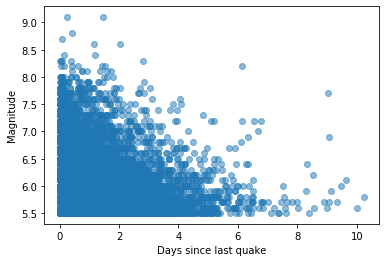

In [5]:
plt.scatter(df.Last_Quake_sec/(60*60*24),df.Magnitude, alpha=0.5)

plt.xlabel('Days since last quake')
plt.ylabel('Magnitude')
plt.show()

# Big quakes are preceeded shortly by other quakes
The hypothesis is **not supported**. In fact, the longer time without a quake, the higher probability that the next quake will be small.

However, this graph does not account for other factors like location and therefore the hypothesis cannot be determined to be inncorrect.

# Earthquakes are random

Even leading science cannot precisly predict earthquakes, however the frequency of earthquakes can still be modeled statistically. The following figure shows a histogram chart of the time between each recorded quake.

Text(0.5, 0, 'Time since last Quake (days)')

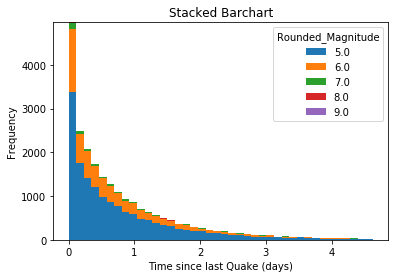

In [6]:
(df[df.Last_Quake_sec < 4*10**5].pivot(columns='Rounded_Magnitude')['Last_Quake_sec']/(60*60*24)).plot(kind = 'hist', stacked=True,bins=40)

plt.title('Stacked Barchart')
plt.xlabel('Time since last Quake (days)')

# The Exponential Distribution
This shape should look familiar to any engineer. It is a decaying exponential. The exponential is a common and well understood distribution. The cumulative and marginal distributions are defined as such,

In [7]:
def cumulative_density(x, lamb):
    return 1 - np.exp(-lamb * x)

def marginal_density(x, lamb):
    return lamb * np.exp(-lamb * x)

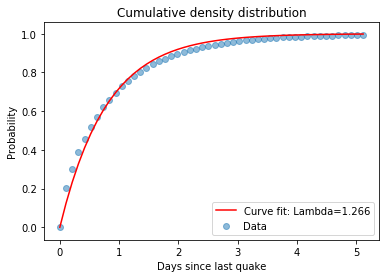

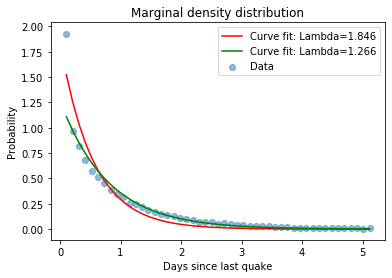

In [20]:
# Fit functions to observed data

density = 50 # Plot resolution

# Cumulative Distribution
max_x = df.Last_Quake_sec.max() / (24*60*60)
x = np.linspace(0,.5*max_x,density)
y = np.linspace(0,0,density)
for i in range(density):
    y[i] = len(df[df.Last_Quake_sec < 24*60*60*x[i]]) / len(df)

plt.scatter(x,y, alpha=0.5, label='Data')

popt, pcov = curve_fit(cumulative_density, x, y)
plt.plot(x, cumulative_density(x, *popt), 'r-',label='Curve fit: Lambda=%5.3f' % tuple(popt))

plt.title('Cumulative density distribution')
plt.xlabel('Days since last quake')
plt.ylabel('Probability')
plt.legend()

#Marginal Distribution
plt.figure()
dx = np.diff(x)
dy = np.diff(y)
new_x = x[1:]

plt.scatter(new_x,dy/dx, alpha=0.5, label='Data')

popt, pcov = curve_fit(marginal_density, new_x, dy/dx)
plt.plot(new_x, marginal_density(new_x, *popt), 'r-',label='Curve fit: Lambda=%5.3f' % tuple(popt))
plt.plot(new_x, marginal_density(new_x, 1.266), 'g-',label='Curve fit: Lambda=1.266')

plt.title('Marginal density distribution')
plt.xlabel('Days since last quake')
plt.ylabel('Probability')
plt.legend()

plt.show()

The exponential distribution has the propterty,

\begin{align}
mean = \frac{1}{\lambda} \\
variance = \frac{1}{\lambda}
\end{align}

So, **on average** earthquakes occour every 0.78 days.

This exponential distribution models the time **betweeen** events, however it is often more useful to predict the number of events in a time period. This is modeled using a sum of exponential distributions that shall be left to the reader to prove. This distribution is commonly refered to as the Poisson Distribution.

# The Poisson Distribution

In [9]:
def pois_marginal_density(x,lamb):
    a = lamb**x
    b = np.exp(-lamb)
    c = np.zeros(len(x))
    c = gamma(x+1)
    return (a * b) / c

Text(0, 0.5, 'Probability')

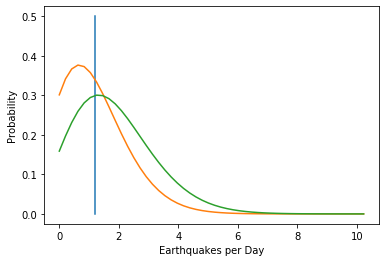

In [21]:
lamb = 1.2
x = np.linspace(0,max_x)
plt.plot([lamb,lamb],[0,.5]) # Mark mean
plt.plot(x,pois_marginal_density(x,lamb))

lamb = 1.84
plt.plot(x,pois_marginal_density(x,lamb))

plt.xlabel('Earthquakes per Day')
plt.ylabel('Probability')

The Poisson distribution has the propterty,

\begin{align}
mean = \lambda \\
variance = \lambda
\end{align}

So, **on average** earth will have 1.2 eathquakes per day

# Are earthquakes uniformily distributed around the globe?

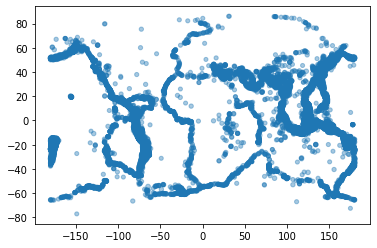

In [11]:
plt.scatter(df.Longitude.values,df.Latitude.values, alpha=0.4, s=3*df.Magnitude.values)

This scatterplot shows the Latitude and Longitude coordinates of each quake in the dataset. The set clearly outlines the tectonic plates.
![tectonic-plates.jpg](tectonic-plates.jpg?)

# Which city has greater danger of earthquakes: San Francisco or Tokyo?

This requires aggregating data by distance from a reference point. Some functions need to be defined first.

## About the distance Funciton
Subtracting latitude and longitude of a quake will not return the distance. This is the same effect that makes Greenland appear nearly as large as Africa on a 2d map.
    
Instead Lat/Long points in spherical space are converted to an x,y,z triple in cartesian space. Then the euclidian distance between quakes and the reference point can be accuratly calculated.
    
 This method should more accuratly assess the proximity of the earthquake since the energy waves travel in a (nearly) straight line through the crust, not along the surface. It should be noted that this does not apply to earthquakes on the opposite side of the earth as the waves do not travel through earths molten core.


In [12]:
# Description:
#   Determines Euclidian (straight line) between 2 points. Does not consider arc length, just straight distance
#   Assumes earth is a sphere with radius=1
#   So the poles are 2 units apart, the equator is sqrt(2) from each pole, not pi and pi/2
# Input:
#   Dataframe with Latitude and Longitude components
#   2 arguments for Lat and Long of reference point
# Output:
#   Series containing distances to the reference point

def distance_from(df, Lat, Long):
    
    Lat = np.deg2rad(Lat) # Convert degrees to radians for numpy trig
    Long = np.deg2rad(Long)
    x_pos = np.cos(Lat)*np.sin(Long) # Convert spherical coordinates to cartesian
    y_pos = np.cos(Lat)*np.cos(Long) # Assumes earths radius = 1
    z_pos = np.sin(Lat)
    
    data_Latitude_rad = np.deg2rad(df.Latitude) # Convert dataframe to radians
    data_Longitude_rad = np.deg2rad(df.Longitude)
    data_x_pos = np.cos(data_Latitude_rad)*np.sin(data_Longitude_rad) # Convert to spherical
    data_y_pos = np.cos(data_Latitude_rad)*np.cos(data_Longitude_rad)
    data_z_pos = np.sin(data_Latitude_rad)
    return ( (data_x_pos - x_pos)**2 + (data_y_pos - y_pos)**2 + (data_z_pos - z_pos)**2)**(1/2) # Pythagoras3D

In [13]:
Tokyo = [35.67,139.65]
San_Fran = [37.77,-122.42]
Denver = [39.74,-104.99]

df['Dist_Tokyo'] = distance_from(df,Tokyo[0],Tokyo[1])
df['Dist_San_Fran'] = distance_from(df,San_Fran[0],San_Fran[1])
df['Dist_Denver'] = distance_from(df,Denver[0],Denver[1])

df.reset_index(drop=True)

,Date,Time,Latitude,Longitude,Type,Magnitude,Datetime,Year,Rounded_Magnitude,Last_Quake,Last_Quake_sec,Dist_Tokyo,Dist_San_Fran,Dist_Denver
0,01/04/1965,11:29:49,1.8630,127.3520,Earthquake,5.8,1965-01-04 11:29:49,1965,5.0,1 days 21:45:31,164731.0,0.612724,1.583197,1.702209
1,01/05/1965,18:05:58,-20.5790,-173.9720,Earthquake,6.2,1965-01-05 18:05:58,1965,6.0,1 days 06:36:09,110169.0,1.166416,1.228930,1.390338
2,01/08/1965,18:49:43,-59.0760,-23.5570,Earthquake,5.8,1965-01-08 18:49:43,1965,5.0,3 days 00:43:45,261825.0,1.949312,1.782142,1.726013
3,01/09/1965,13:32:50,11.9380,126.4270,Earthquake,5.8,1965-01-09 13:32:50,1965,5.0,0 days 18:43:07,67387.0,0.459641,1.518147,1.635202
4,01/10/1965,13:36:32,-13.4050,166.6290,Earthquake,6.7,1965-01-10 13:36:32,1965,6.0,1 days 00:03:42,86622.0,0.928365,1.334940,1.501385
5,01/12/1965,13:32:25,27.3570,87.8670,Earthquake,5.9,1965-01-12 13:32:25,1965,5.0,1 days 23:55:53,172553.0,0.755869,1.627749,1.656532
6,01/15/1965,23:17:42,-13.3090,166.2120,Earthquake,6.0,1965-01-15 23:17:42,1965,6.0,3 days 09:45:17,294317.0,0.924238,1.338082,1.504309
7,01/16/1965,11:32:37,-56.4520,-27.0430,Earthquake,6.0,1965-01-16 11:32:37,1965,6.0,0 days 12:14:55,44095.0,1.961063,1.761478,1.699456
8,01/17/1965,10:43:17,-24.5630,178.4870,Earthquake,5.8,1965-01-17 10:43:17,1965,5.0,0 days 23:10:40,83440.0,1.154873,1.330660,1.485102
9,01/17/1965,20:57:41,-6.8070,108.9880,Earthquake,5.9,1965-01-17 20:57:41,1965,5.0,0 days 10:14:24,36864.0,0.866291,1.767595,1.848748


# How far away can you feel a strong quake?
The [US Geological Program (USGS)](https://earthquake.usgs.gov/learn/topics/mag-intensity/) cites that even somewhat large earhquakes dissapate quickly over an area. The tremors can hardly be felt more than just 100km or about 1 degree away.
![Quake_Strength_Heatmap.jpg](Quake_Strength_Heatmap.jpg?)

There are clearly other factors to consider before estimating damages. Soil content can affect energy dissapation and other secondary effects like tsunamis can cause significant damage

# Calculating distance threshold

More precicely, 100km == 0.899 deg, but lets round up.

In [14]:
earth_radius = 6371 # kilometers
earth_circumfrence = earth_radius * 3.14 * 2
km_per_deg = earth_circumfrence / 360
print(100/km_per_deg)

0.8997777548945409


1 degree maps to 0.017 in the distance space.

In [15]:
q = pd.DataFrame.from_dict({'Latitude': [0], 'Longitude': [0]})
distance_from(q,0,1)

0    0.017453
dtype: float64

For reference, the distance between SF and LA is 0.088

In [16]:
print(San_Fran)
q = pd.DataFrame.from_dict({'Latitude': [San_Fran[0]], 'Longitude': [San_Fran[1]]})
distance_from(q,34.05,-118.24) # Distance to LA

[37.77, -122.42]


0    0.08774
dtype: float64

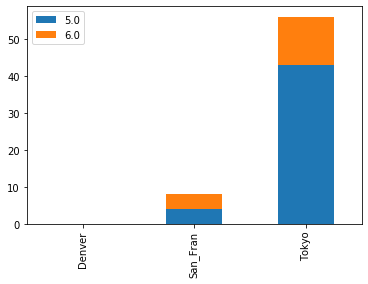

In [17]:
Local_Dist = .017

Denver_Local_Counts = df[df.Dist_Denver < Local_Dist].Rounded_Magnitude.value_counts()
San_Fran_Local_Counts = df[df.Dist_San_Fran < Local_Dist].Rounded_Magnitude.value_counts()
Tokyo_Local_Counts = df[df.Dist_Tokyo < Local_Dist].Rounded_Magnitude.value_counts()

counts = pd.concat({'Denver':Denver_Local_Counts, 'San_Fran':San_Fran_Local_Counts, 'Tokyo':Tokyo_Local_Counts}, axis = 1).fillna(0)
counts.transpose().plot(kind='bar',stacked=True)


# Tokyo has significantly more earthquakes than San Francisco or Denver